# **Quantitative analysis using stock price data and technical indicators**

---
---

### **Setup**

---

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
import pytz
from IPython.display import display
import matplotlib.pyplot as plt
import sys
import os
import seaborn as sns

from ta.trend import SMAIndicator, MACD
from ta.momentum import RSIIndicator

### **1. Data Preparation and Cleaning**

----

### Tickers
- AAPL: Apple Inc.
- AMZN: Amazon.com. Inc.
- GOOG: Alphabet Inc. (Class C)
- FB: Meta Platforms, Inc.
- MSF: Microsoft Corporation
- NVDA: NVIDIA Corporation
- TSLA: Tesla, Inc.

In [2]:
# Load a CSV file from your local file system
df_Apple = pd.read_csv('C:/Users/Admin/OneDrive/10 Academy/Week 1/Technical Content/Data/yfinance_data/AAPL_historical_data.csv')
df_Amazon = pd.read_csv('C:/Users/Admin/OneDrive/10 Academy/Week 1/Technical Content/Data/yfinance_data/AMZN_historical_data.csv')
df_Alphabet = pd.read_csv('C:/Users/Admin/OneDrive/10 Academy/Week 1/Technical Content/Data/yfinance_data/GOOG_historical_data.csv')
df_Meta = pd.read_csv('C:/Users/Admin/OneDrive/10 Academy/Week 1/Technical Content/Data/yfinance_data/META_historical_data.csv')
df_Microsoft = pd.read_csv('C:/Users/Admin/OneDrive/10 Academy/Week 1/Technical Content/Data/yfinance_data/MSFT_historical_data.csv')
df_NVIDIA = pd.read_csv('C:/Users/Admin/OneDrive/10 Academy/Week 1/Technical Content/Data/yfinance_data/NVDA_historical_data.csv')
df_TSLA = pd.read_csv('C:/Users/Admin/OneDrive/10 Academy/Week 1/Technical Content/Data/yfinance_data/TSLA_historical_data.csv')

# Add a 'Ticker' column to each DataFrame
df_Apple['Ticker'] = 'AAPL'
df_Amazon['Ticker'] = 'AMZN'
df_Alphabet['Ticker'] = 'GOOG'
df_Meta['Ticker'] = 'FB'
df_Microsoft['Ticker'] = 'MSF'
df_NVIDIA['Ticker'] = 'NVDA'
df_TSLA['Ticker'] = 'TSLA'

# Combine all DataFrames into one
df = pd.concat([df_Apple, df_Amazon, df_Alphabet, df_Meta, df_Microsoft, df_NVIDIA, df_TSLA], ignore_index=True)

In [3]:
# Check for missing values and data types
print(df.info())
print(df.isnull().sum())


# Convert 'Date' column to datetime if not already
df['Date']= pd.to_datetime(df['Date'], errors='coerce')


# Drop rows with missing or invalid dates
df = df.dropna(subset=['Date'])


# Ensure numeric columns are correct type
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividends', 'Stock Splits']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')


# Drop rows with any remaining missing values in critical columns
df = df.dropna(subset=numeric_cols)


# Reset index after cleaning
df = df.reset_index(drop=True)


# Display cleaned dataframe info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45428 entries, 0 to 45427
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          45428 non-null  object 
 1   Open          45428 non-null  float64
 2   High          45428 non-null  float64
 3   Low           45428 non-null  float64
 4   Close         45428 non-null  float64
 5   Adj Close     45428 non-null  float64
 6   Volume        45428 non-null  int64  
 7   Dividends     45428 non-null  float64
 8   Stock Splits  45428 non-null  float64
 9   Ticker        45428 non-null  object 
dtypes: float64(7), int64(1), object(2)
memory usage: 3.5+ MB
None
Date            0
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
Dividends       0
Stock Splits    0
Ticker          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45428 entries, 0 to 45427
Data columns (total 10 columns):
 #   C

### **Summary of Data Preparation**

The data preparation process involved several key steps to ensure the integrity and usability of the stock price dataset:
- Missing Values & Data Types: Checked for missing values and verified data types for all columns.
- Date Conversion: Converted the 'Date' column to datetime format and removed any rows with invalid or missing dates.
- Numeric Columns: Ensured all price and volume-related columns (`Open`. `High`. `Low`, `Close`, `Adj close`, `Volume`, `Dividends`, `Stock Splits`) are of numeric type, coercing errors to NaN.
- Data Cleaning: Dropped rows with missing values in critical numeric columns to maintain data quality.
- Index Reset: Reset the DataFrame index after cleaning for consistency.
- Result: The cleaned DataFrame df contains reliable, well-typed historical stock data for multiple major companies, ready for further analysis.

----

### **2. Technical Indicator Computation**

In [5]:
# Calculate 20-day and 50-day Simple Moving Averages (SMA) for each ticker using ta
df['SMA_20'] = df.groupby('Ticker')['Close'].transform(lambda x: SMAIndicator(x, window=20).sma_indicator())
df['SMA_50'] = df.groupby('Ticker')['Close'].transform(lambda x: SMAIndicator(x, window=50).sma_indicator())

# Display the first few rows to verify
display(df[['Date', 'Ticker', 'Close', 'SMA_20', 'SMA_50']].head(100))

,Date,Ticker,Close,SMA_20,SMA_50
0,1980-12-12,AAPL,0.128348,NaN,NaN
1,1980-12-15,AAPL,0.121652,NaN,NaN
2,1980-12-16,AAPL,0.112723,NaN,NaN
3,1980-12-17,AAPL,0.115513,NaN,NaN
4,1980-12-18,AAPL,0.118862,NaN,NaN
...,...,...,...,...,...
95,1981-04-30,AAPL,0.126674,0.122210,0.115513
96,1981-05-01,AAPL,0.126674,0.122656,0.115759
97,1981-05-04,AAPL,0.126116,0.123047,0.116116
98,1981-05-05,AAPL,0.125558,0.123521,0.116429


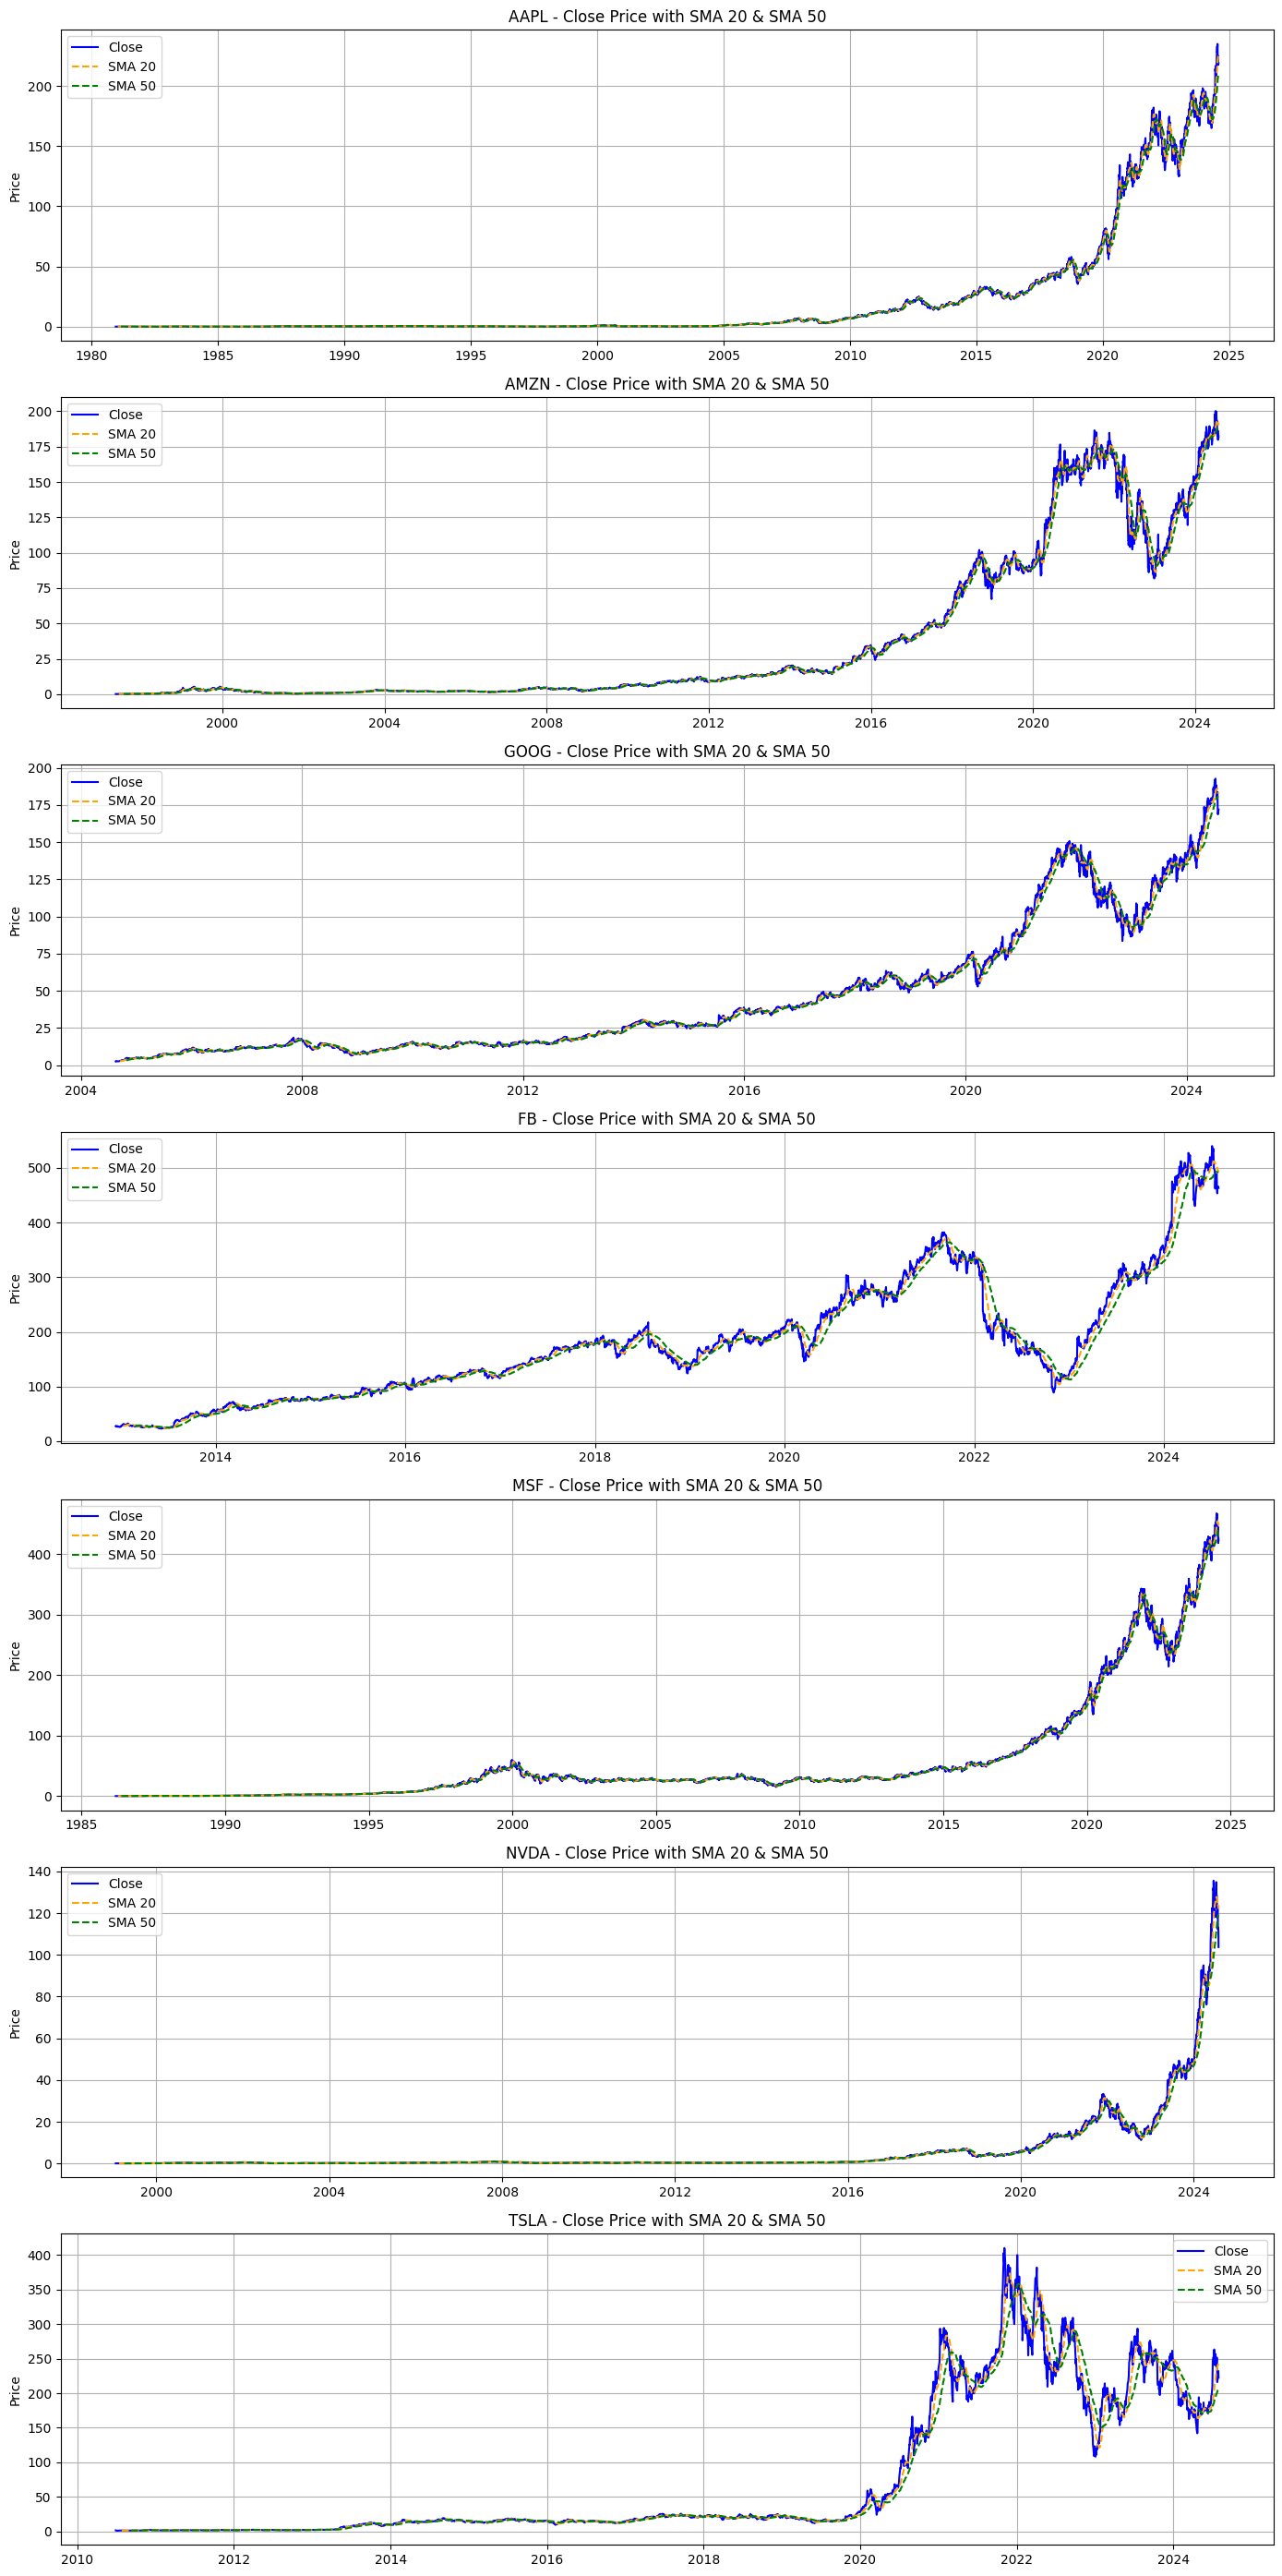

In [6]:
# Visualize each Ticker's Close price with SMA_20 and SMA_50 overlays using subplots

tickers = df['Ticker'].unique()
num_tickers = len(tickers)
fig, axes = plt.subplots(num_tickers, 1, figsize=(14, 4 * num_tickers), sharex=False)

if num_tickers == 1:
    axes = [axes]

for i, ticker in enumerate(tickers):
    ax = axes[i]
    data = df[df['Ticker'] == ticker]
    ax.plot(data['Date'], data['Close'], label='Close', color='blue')
    ax.plot(data['Date'], data['SMA_20'], label='SMA 20', color='orange', linestyle='--')
    ax.plot(data['Date'], data['SMA_50'], label='SMA 50', color='green', linestyle='--')
    ax.set_title(f'{ticker} - Close Price with SMA 20 & SMA 50')
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()